<a href="https://colab.research.google.com/github/NhatVu/Customer_clustering/blob/main/ca683_Assignmen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>pre { white-space: pre !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime as dt
from tabulate import tabulate
from sklearn.cluster import KMeans
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn import metrics

C:\Users\Minh Nhat\AppData\Local\Temp\ipykernel_22488\3299008526.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Understanding the data before processing

In [2]:
unified_data = pd.read_parquet('./online_retail_clean.parquet')

I think two aspects can improve RFM:
* A group of customers can buy a group of products more frequently than other products. We can add products aspect to the RFM model 
* The origin RFM only provide the overview and does not care about the season factors. Customer buying behaviour can vary by season. We can calculate RFM for each month 

So, we can create RFM/product/month
Now, the number of features = 3 * # products * 12


Attribute Information:

* InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.
* StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product.
* Description: Product (item) name. Nominal.
* Quantity: The quantities of each product (item) per transaction. Numeric.
* InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated.
* UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£).
* CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.
Country: Country name. Nominal. The name of the country where a customer resides.

In [3]:
product_counts = unified_data['StockCode'].value_counts()

# I think we will remove the product that have frequent of buying less than 25% percentage 
product_counts_threshold = np.percentile(product_counts.values, [25])[0]
filter_product_counts = product_counts[product_counts > product_counts_threshold]

# filter out that StockCodes don't satisfy the condition 
unified_data = unified_data[unified_data['StockCode'].isin(filter_product_counts.index)]

In [4]:
print(f'unique size stockcode: {unified_data["StockCode"].value_counts().size}')

unique size stockcode: 2701


## Features: RFM / product / month

In [5]:
# Retrieve Recency, Frequency, Monetary
examined_date = unified_data["InvoiceDate"].max()
unified_data["PurchaseIntervalTime"] = unified_data["InvoiceDate"]
unified_data["TotalSpent"]= unified_data["Price"]*unified_data["Quantity"]
new_advanced_field = {
    "InvoiceDate":lambda date:(examined_date-date.max()).days,
    "Invoice":lambda num: num.nunique(),
    "TotalSpent": lambda price:price.sum(),
    "PurchaseIntervalTime":lambda date: (examined_date - date.min()).days
}
grouped_df = unified_data.groupby([unified_data['Customer ID'], unified_data['StockCode'], unified_data['InvoiceDate'].dt.month])

advanced_rfm_df = grouped_df.agg(new_advanced_field)
advanced_rfm_df.columns=["Recency","Frequency","Monetary","Tenure"]

# advanced_rfm_df["Recency"]=advanced_rfm_df["Recency"]/advanced_rfm_df["Frequency"]
advanced_rfm_df["Monetary"]=advanced_rfm_df["Monetary"]/advanced_rfm_df["Frequency"]
# Remove any monetary equal to 0
advanced_rfm_df = advanced_rfm_df[advanced_rfm_df["Monetary"]!=0]
print(advanced_rfm_df.head())


                                   Recency  Frequency  Monetary  Tenure
Customer ID StockCode InvoiceDate                                      
12347.0     16008     4                246          1       6.0     246
            17021     6                182          1      10.8     182
            20665     4                246          1      17.7     246
            20719     1                316          1       8.5     316
                      8                129          1       8.5     129


In [6]:
a = advanced_rfm_df.unstack(level=['InvoiceDate', 'StockCode'])
a

Recency                                                        \
InvoiceDate      4      6      4      1      8     10    12                 
StockCode     16008  17021  20665  20719  20719 20719 20719  20780  20782   
Customer ID                                                                 
12347.0       246.0  182.0  246.0  316.0  129.0  39.0   1.0  366.0  366.0   
12348.0         NaN    NaN    NaN    NaN    NaN   NaN   NaN    NaN    NaN   
12349.0         NaN    NaN    NaN    NaN    NaN   NaN   NaN    NaN    NaN   
12350.0         NaN    NaN    NaN    NaN    NaN   NaN   NaN    NaN    NaN   
12352.0         NaN    NaN    NaN    NaN    NaN   NaN   NaN    NaN    NaN   
...             ...    ...    ...    ...    ...   ...   ...    ...    ...   
18280.0         NaN    NaN    NaN    NaN    NaN   NaN   NaN    NaN    NaN   
18281.0         NaN    NaN    NaN    NaN    NaN   NaN   NaN    NaN    NaN   
18282.0         NaN    NaN    NaN    NaN    NaN   NaN   NaN    NaN    NaN   
18283.0         NaN    NaN    NaN  319.0    NaN   NaN   NaN    NaN    NaN   
18287.0         NaN    NaN    NaN    NaN    NaN   NaN   NaN    NaN    NaN   

                    ... Tenure                                                \
InvoiceDate     1   ...     8      1      8     5      12          3      8    
StockCode    20966  ...  23036 84927A 84509G 22858 84249A 84457 35923  21109   
Customer ID         ...                                                        
12347.0      316.0  ...    NaN    NaN    NaN   NaN    NaN   NaN   NaN    NaN   
12348.0        NaN  ...    NaN    NaN    NaN   NaN    NaN   NaN   NaN    NaN   
12349.0        NaN  ...    NaN    NaN    NaN   NaN    NaN   NaN   NaN    NaN   
12350.0        NaN  ...    NaN    NaN    NaN   NaN    NaN   NaN   NaN    NaN   
12352.0        NaN  ...    NaN    NaN    NaN   NaN    NaN   NaN   NaN    NaN   
...            ...  ...    ...    ...    ...   ...    ...   ...   ...    ...   
18280.0        NaN  ...    NaN    NaN    NaN   NaN    NaN   NaN   NaN    NaN   
18281.0        NaN  ...    NaN    NaN    NaN   NaN    NaN   NaN   NaN    NaN   
18282.0        NaN  ...    NaN    NaN    NaN   NaN    NaN   NaN   NaN  125.0   
18283.0        NaN  ...    NaN    NaN    NaN   NaN    NaN   NaN   NaN    NaN   
18287.0        NaN  ...    NaN    NaN    NaN   NaN    NaN   NaN   NaN    NaN   

                          
InvoiceDate    12     5   
StockCode   90099  21382  
Customer ID               
12347.0       NaN    NaN  
12348.0       NaN    NaN  
12349.0       NaN    NaN  
12350.0       NaN    NaN  
12352.0       NaN    NaN  
...           ...    ...  
18280.0       NaN    NaN  
18281.0       NaN    NaN  
18282.0       NaN    NaN  
18283.0       3.0    NaN  
18287.0       NaN  201.0  

[4272 rows x 102012 columns]

In [7]:
# with 81248 dimension, the null value occupy 99.61% positions ==> not good. The data is sparse and ecludian distance doesn't work well anymore
# furthermore, shape [4264 rows × 81248 columns] => features >> records. In ML, it can introduce overfitting because the data is not enough to generalize the model. But in clustering, does it harm the cluster process? I think it is

a.isnull().mean().mean()

0.9967938430827041

### Features: RFM / month

In [8]:
from datetime import datetime
from calendar import monthrange

def last_day_of_month(date_value):
    return date_value.replace(day = monthrange(date_value.year, date_value.month)[1])

given_date = unified_data['InvoiceDate'].max()
print("\nLast day of month:", last_day_of_month(given_date))

# So, I only care about the RFMT/monthly 
examined_date = unified_data["InvoiceDate"].max()
unified_data["PurchaseIntervalTime"] = unified_data["InvoiceDate"]
unified_data["TotalSpent"]= unified_data["Price"]*unified_data["Quantity"]
new_advanced_field = {
    "InvoiceDate":lambda date:(min(examined_date, last_day_of_month(date.max())) -date.max()).days,
    "Invoice":lambda num: num.nunique(),
    "TotalSpent": lambda price:price.sum(),
}
grouped_df = unified_data.groupby([unified_data['Customer ID'], unified_data['InvoiceDate'].dt.month])

advanced_rfm_df = grouped_df.agg(new_advanced_field)
advanced_rfm_df.columns=["Recency","Frequency","Monetary"]

advanced_rfm_df["Monetary"]=advanced_rfm_df["Monetary"]/advanced_rfm_df["Frequency"]
# Remove any monetary equal to 0
advanced_rfm_df = advanced_rfm_df[advanced_rfm_df["Monetary"]!=0]

advanced_rfm_df = advanced_rfm_df.unstack(level=['InvoiceDate'])
advanced_rfm_df


Last day of month: 2011-12-31 12:50:00


Recency                                                      ...  \
InvoiceDate      1     2     3     4    5     6     7     8     9    10  ...   
Customer ID                                                              ...   
12347.0         5.0   NaN   NaN  23.0  NaN  21.0   NaN  29.0   NaN  0.0  ...   
12348.0         6.0   NaN   NaN  25.0  NaN   NaN   NaN   NaN   5.0  NaN  ...   
12349.0         NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN   NaN  NaN  ...   
12350.0         NaN  26.0   NaN   NaN  NaN   NaN   NaN   NaN   NaN  NaN  ...   
12352.0         NaN  12.0   9.0   NaN  NaN   NaN   NaN   NaN   2.0  NaN  ...   
...             ...   ...   ...   ...  ...   ...   ...   ...   ...  ...  ...   
18280.0         NaN   NaN  24.0   NaN  NaN   NaN   NaN   NaN   NaN  NaN  ...   
18281.0         NaN   NaN   NaN   NaN  NaN  18.0   NaN   NaN   NaN  NaN  ...   
18282.0         NaN   NaN   NaN   NaN  NaN   NaN   NaN  26.0   NaN  NaN  ...   
18283.0         8.0   0.0   NaN   9.0  8.0   7.0  17.0   NaN  25.0  4.0  ...   
18287.0         NaN   NaN   NaN   NaN  9.0   NaN   NaN   NaN   NaN  3.0  ...   

               Monetary                                                   \
InvoiceDate          3       4       5        6       7       8       9    
Customer ID                                                                
12347.0             NaN  386.65     NaN  382.520     NaN  584.91     NaN   
12348.0             NaN  327.00     NaN      NaN     NaN     NaN  120.00   
12349.0             NaN     NaN     NaN      NaN     NaN     NaN     NaN   
12350.0             NaN     NaN     NaN      NaN     NaN     NaN     NaN   
12352.0      115.003333     NaN     NaN      NaN     NaN     NaN  256.25   
...                 ...     ...     ...      ...     ...     ...     ...   
18280.0      180.600000     NaN     NaN      NaN     NaN     NaN     NaN   
18281.0             NaN     NaN     NaN   46.920     NaN     NaN     NaN   
18282.0             NaN     NaN     NaN      NaN     NaN  100.21     NaN   
18283.0             NaN  111.78   99.47  153.765  71.595     NaN  134.90   
18287.0             NaN     NaN  765.28      NaN     NaN     NaN     NaN   

                                        
InvoiceDate       10       11       12  
Customer ID                             
12347.0      1294.32      NaN  449.555  
12348.0          NaN      NaN  367.680  
12349.0          NaN  1353.80      NaN  
12350.0          NaN      NaN      NaN  
12352.0          NaN   231.73      NaN  
...              ...      ...      ...  
18280.0          NaN      NaN      NaN  
18281.0          NaN      NaN      NaN  
18282.0          NaN      NaN   77.840  
18283.0        98.70   162.89  208.000  
18287.0       536.00      NaN      NaN  

[4272 rows x 36 columns]

In [9]:
# check null 
advanced_rfm_df.isnull().mean().mean()

0.7548962234706615

In [10]:
advanced_rfm_df.isnull().sum().sum() / (advanced_rfm_df.shape[0] * advanced_rfm_df.shape[1])

0.7548962234706617

### Features: RFM / Quarter

In [11]:
# So, I only care about the RFMT/monthly 
examined_date = unified_data["InvoiceDate"].max()
unified_data["PurchaseIntervalTime"] = unified_data["InvoiceDate"]
unified_data["TotalSpent"]= unified_data["Price"]*unified_data["Quantity"]
new_advanced_field = {
    "InvoiceDate":lambda date:(min(examined_date, last_day_of_month(date.max())) -date.max()).days,
    "Invoice":lambda num: num.nunique(),
    "TotalSpent": lambda price:price.sum(),
}
grouped_df = unified_data.groupby([unified_data['Customer ID'], unified_data['InvoiceDate'].dt.to_period('Q')])

advanced_rfm_df = grouped_df.agg(new_advanced_field)
advanced_rfm_df.columns=["Recency","Frequency","Monetary"]

# advanced_rfm_df["Recency"]=advanced_rfm_df["Recency"]/advanced_rfm_df["Frequency"]
advanced_rfm_df["Monetary"]=advanced_rfm_df["Monetary"]/advanced_rfm_df["Frequency"]
# Remove any monetary equal to 0
advanced_rfm_df = advanced_rfm_df[advanced_rfm_df["Monetary"]!=0]

advanced_rfm_df = advanced_rfm_df.unstack(level=['InvoiceDate'])
advanced_rfm_df

Recency                             Frequency                \
InvoiceDate  2010Q4 2011Q1 2011Q2 2011Q3 2011Q4    2010Q4 2011Q1 2011Q2   
Customer ID                                                               
12347.0        24.0    5.0   21.0   29.0    1.0       1.0    1.0    2.0   
12348.0        15.0    6.0   25.0    5.0    NaN       1.0    1.0    1.0   
12349.0         NaN    NaN    NaN    NaN    9.0       NaN    NaN    NaN   
12350.0         NaN   26.0    NaN    NaN    NaN       NaN    1.0    NaN   
12352.0         NaN    9.0    NaN    2.0   27.0       NaN    4.0    NaN   
...             ...    ...    ...    ...    ...       ...    ...    ...   
18280.0         NaN   24.0    NaN    NaN    NaN       NaN    1.0    NaN   
18281.0         NaN    NaN   18.0    NaN    NaN       NaN    NaN    1.0   
18282.0         NaN    NaN    NaN   26.0    7.0       NaN    NaN    NaN   
18283.0         NaN    0.0    7.0   25.0    3.0       NaN    3.0    4.0   
18287.0         NaN    NaN    9.0    NaN    3.0       NaN    NaN    1.0   

                          Monetary                                            
InvoiceDate 2011Q3 2011Q4   2010Q4      2011Q1   2011Q2      2011Q3   2011Q4  
Customer ID                                                                   
12347.0        1.0    2.0   674.29  475.390000  384.585  584.910000   759.57  
12348.0        1.0    NaN   367.68   20.400000  327.000  120.000000      NaN  
12349.0        NaN    1.0      NaN         NaN      NaN         NaN  1353.80  
12350.0        NaN    NaN      NaN  294.400000      NaN         NaN      NaN  
12352.0        2.0    1.0      NaN  160.377500      NaN  256.250000   231.73  
...            ...    ...      ...         ...      ...         ...      ...  
18280.0        NaN    NaN      NaN  180.600000      NaN         NaN      NaN  
18281.0        NaN    NaN      NaN         NaN   46.920         NaN      NaN  
18282.0        1.0    1.0      NaN         NaN      NaN  100.210000    77.84  
18283.0        3.0    6.0      NaN  104.866667  129.695   92.696667   159.71  
18287.0        NaN    2.0      NaN         NaN  765.280         NaN   536.00  

[4272 rows x 15 columns]

In [12]:
advanced_rfm_df.isnull().mean().mean()

0.5688202247191011

In [13]:
# Recency: fillna with 30 (smaller is better)
advanced_rfm_df['Recency'] = advanced_rfm_df['Recency'].fillna(30 * 3)
# Frequency, Monetary: fillna with 0
advanced_rfm_df['Frequency'] =  advanced_rfm_df['Frequency'].fillna(0)
advanced_rfm_df['Monetary'] = advanced_rfm_df['Monetary'].fillna(0)
advanced_rfm_df

Recency                             Frequency                \
InvoiceDate  2010Q4 2011Q1 2011Q2 2011Q3 2011Q4    2010Q4 2011Q1 2011Q2   
Customer ID                                                               
12347.0        24.0    5.0   21.0   29.0    1.0       1.0    1.0    2.0   
12348.0        15.0    6.0   25.0    5.0   90.0       1.0    1.0    1.0   
12349.0        90.0   90.0   90.0   90.0    9.0       0.0    0.0    0.0   
12350.0        90.0   26.0   90.0   90.0   90.0       0.0    1.0    0.0   
12352.0        90.0    9.0   90.0    2.0   27.0       0.0    4.0    0.0   
...             ...    ...    ...    ...    ...       ...    ...    ...   
18280.0        90.0   24.0   90.0   90.0   90.0       0.0    1.0    0.0   
18281.0        90.0   90.0   18.0   90.0   90.0       0.0    0.0    1.0   
18282.0        90.0   90.0   90.0   26.0    7.0       0.0    0.0    0.0   
18283.0        90.0    0.0    7.0   25.0    3.0       0.0    3.0    4.0   
18287.0        90.0   90.0    9.0   90.0    3.0       0.0    0.0    1.0   

                          Monetary                                            
InvoiceDate 2011Q3 2011Q4   2010Q4      2011Q1   2011Q2      2011Q3   2011Q4  
Customer ID                                                                   
12347.0        1.0    2.0   674.29  475.390000  384.585  584.910000   759.57  
12348.0        1.0    0.0   367.68   20.400000  327.000  120.000000     0.00  
12349.0        0.0    1.0     0.00    0.000000    0.000    0.000000  1353.80  
12350.0        0.0    0.0     0.00  294.400000    0.000    0.000000     0.00  
12352.0        2.0    1.0     0.00  160.377500    0.000  256.250000   231.73  
...            ...    ...      ...         ...      ...         ...      ...  
18280.0        0.0    0.0     0.00  180.600000    0.000    0.000000     0.00  
18281.0        0.0    0.0     0.00    0.000000   46.920    0.000000     0.00  
18282.0        1.0    1.0     0.00    0.000000    0.000  100.210000    77.84  
18283.0        3.0    6.0     0.00  104.866667  129.695   92.696667   159.71  
18287.0        0.0    2.0     0.00    0.000000  765.280    0.000000   536.00  

[4272 rows x 15 columns]

## Data Mining & Analyse the advanced RFMT figures

In [14]:
# flow: remove top 1% from original data -> min-max sacle -> draw histogram plot -> if right skew, use log-transform 

In [15]:
# # Examine the shape of the distribution of the current data
# plt.figure(figsize=(20,16));
# # Plot the distributions of R,F,M
# plt.subplot(4,2,1);
# sns.histplot(advanced_rfm_df["Recency"]).set(title="Distribution of Recency");
# plt.subplot(4,2,2);
# sns.histplot(advanced_rfm_df["Frequency"]).set(title="Distribution of Frequency");
# plt.subplot(4,2,3);
# sns.histplot(advanced_rfm_df["Monetary"]).set(title="Distribution of Monetary");
# # plt.subplot(4,2,4);
# # sns.histplot(advanced_rfm_df["Tenure"]).set(title="Distribution of Tenure");
# # set the spacing between subplots
# plt.subplots_adjust(left=0.1,
#                     bottom=0.1, 
#                     right=0.9, 
#                     top=0.9, 
#                     wspace=0.2, 
#                     hspace=0.4)

In [16]:
column_names = []
for tuple_columns in advanced_rfm_df.columns:
    column_names.append(f'{tuple_columns[0]}_{tuple_columns[1]}')

print(column_names)
advanced_rfm_df.columns = column_names

['Recency_2010Q4', 'Recency_2011Q1', 'Recency_2011Q2', 'Recency_2011Q3', 'Recency_2011Q4', 'Frequency_2010Q4', 'Frequency_2011Q1', 'Frequency_2011Q2', 'Frequency_2011Q3', 'Frequency_2011Q4', 'Monetary_2010Q4', 'Monetary_2011Q1', 'Monetary_2011Q2', 'Monetary_2011Q3', 'Monetary_2011Q4']


In [17]:
advanced_rfm_df.head()

,Recency_2010Q4,Recency_2011Q1,Recency_2011Q2,Recency_2011Q3,Recency_2011Q4,Frequency_2010Q4,Frequency_2011Q1,Frequency_2011Q2,Frequency_2011Q3,Frequency_2011Q4,Monetary_2010Q4,Monetary_2011Q1,Monetary_2011Q2,Monetary_2011Q3,Monetary_2011Q4
Customer ID,,,,,,,,,,,,,,,
12347.0,24.0,5.0,21.0,29.0,1.0,1.0,1.0,2.0,1.0,2.0,674.29,475.3900,384.585,584.91,759.57
12348.0,15.0,6.0,25.0,5.0,90.0,1.0,1.0,1.0,1.0,0.0,367.68,20.4000,327.000,120.00,0.00
12349.0,90.0,90.0,90.0,90.0,9.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0000,0.000,0.00,1353.80
12350.0,90.0,26.0,90.0,90.0,90.0,0.0,1.0,0.0,0.0,0.0,0.00,294.4000,0.000,0.00,0.00
12352.0,90.0,9.0,90.0,2.0,27.0,0.0,4.0,0.0,2.0,1.0,0.00,160.3775,0.000,256.25,231.73


In [18]:
# advanced_rfm_df = advanced_rfm_df[advanced_rfm_df["Recency"]!=0]
# Because the data is skewed to the right so we need to transform by using Log Transformation
advanced_rfm_df = np.log(advanced_rfm_df + 1)
# advanced_rfm_df["T_log"] = np.log(advanced_rfm_df["Tenure"]+1)

# # Plot RFM distribution again
# plt.figure(figsize=(16,14))
# plt.subplot(3,1,1)
# sns.distplot(advanced_rfm_df["R_log"])
# plt.subplot(3,1,2);
# sns.distplot(advanced_rfm_df["F_log"] )
# plt.subplot(3,1,3)
# sns.distplot(advanced_rfm_df["M_log"])
# # plt.subplot(4,1,4)
# # sns.distplot(advanced_rfm_df["T_log"])
# plt.show();

In [19]:
advanced_rfm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency_2010Q4,4272.0,4.207582,0.618902,2.197225,4.510860,4.510860,4.510860,4.510860
Recency_2011Q1,4272.0,3.605648,1.246683,0.000000,2.772589,4.510860,4.510860,4.510860
Recency_2011Q2,4272.0,3.595936,1.139580,0.000000,2.833213,4.510860,4.510860,4.510860
Recency_2011Q3,4272.0,3.428097,1.253176,0.000000,2.564949,4.510860,4.510860,4.510860
Recency_2011Q4,4272.0,3.077438,1.406954,0.000000,2.079442,3.091042,4.510860,4.510860
Frequency_2010Q4,4272.0,0.173805,0.374228,0.000000,0.000000,0.000000,0.000000,3.555348
Frequency_2011Q1,4272.0,0.378616,0.522807,0.000000,0.000000,0.000000,0.693147,3.258097
Frequency_2011Q2,4272.0,0.446678,0.566177,0.000000,0.000000,0.000000,0.693147,3.806662
Frequency_2011Q3,4272.0,0.484171,0.567290,0.000000,0.000000,0.000000,0.693147,4.007333
Frequency_2011Q4,4272.0,0.586592,0.585689,0.000000,0.000000,0.693147,1.098612,4.219508


In [20]:
# R, F, M and T have different scale, using MinMaxScaler to remove the effect of different unit metric 

from sklearn.preprocessing import MinMaxScaler
# Standardize mean and standard deviation
scaler = MinMaxScaler()
ad_data_process_log = advanced_rfm_df[column_names]
# ad_data_process_log = advanced_rfm_df[["R_log","F_log","M_log","T_log"]]
scaler.fit(ad_data_process_log)
ad_data_process_norm = scaler.transform(ad_data_process_log)
ad_data_process_norm_df = pd.DataFrame(ad_data_process_norm)
ad_data_process_norm_df.columns = column_names
ad_data_process_norm_df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Recency_2010Q4,4272.0,0.87,0.27,0.0,1.00,1.00,1.00,1.0
Recency_2011Q1,4272.0,0.80,0.28,0.0,0.61,1.00,1.00,1.0
Recency_2011Q2,4272.0,0.80,0.25,0.0,0.63,1.00,1.00,1.0
Recency_2011Q3,4272.0,0.76,0.28,0.0,0.57,1.00,1.00,1.0
Recency_2011Q4,4272.0,0.68,0.31,0.0,0.46,0.69,1.00,1.0
Frequency_2010Q4,4272.0,0.05,0.11,0.0,0.00,0.00,0.00,1.0
Frequency_2011Q1,4272.0,0.12,0.16,0.0,0.00,0.00,0.21,1.0
Frequency_2011Q2,4272.0,0.12,0.15,0.0,0.00,0.00,0.18,1.0
Frequency_2011Q3,4272.0,0.12,0.14,0.0,0.00,0.00,0.17,1.0
Frequency_2011Q4,4272.0,0.14,0.14,0.0,0.00,0.16,0.26,1.0


In [21]:
ad_data_process_norm_df.quantile([.25, 0.5, 0.75, 0.8, 0.9, 0.99], axis=0).T

,0.25,0.50,0.75,0.80,0.90,0.99
Recency_2010Q4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Recency_2011Q1,0.614648,1.000000,1.000000,1.000000,1.000000,1.000000
Recency_2011Q2,0.628087,1.000000,1.000000,1.000000,1.000000,1.000000
Recency_2011Q3,0.568617,1.000000,1.000000,1.000000,1.000000,1.000000
Recency_2011Q4,0.460986,0.685245,1.000000,1.000000,1.000000,1.000000
Frequency_2010Q4,0.000000,0.000000,0.000000,0.194959,0.194959,0.389918
Frequency_2011Q1,0.000000,0.000000,0.212746,0.212746,0.337195,0.638238
Frequency_2011Q2,0.000000,0.000000,0.182088,0.182088,0.288602,0.577205
Frequency_2011Q3,0.000000,0.000000,0.172970,0.274150,0.274150,0.548301
Frequency_2011Q4,0.000000,0.164272,0.260365,0.260365,0.328544,0.520730


## PCA

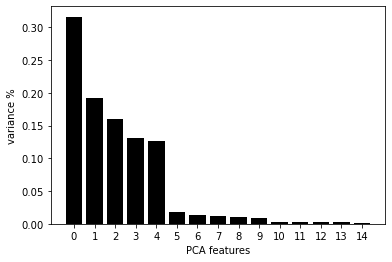

In [22]:
from sklearn.decomposition import PCA
# Standardize the data to have a mean of ~0 and a variance of 1
# x_std = StandardScaler().fit_transform(ad_data_process_log)
# Create a PCA instance: pca
pca = PCA(n_components=len(column_names))
principalComponents = pca.fit_transform(ad_data_process_norm)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black');
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

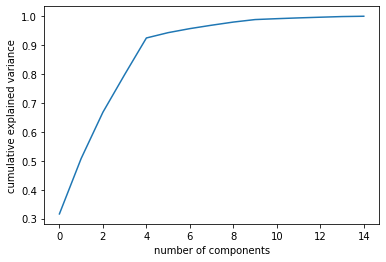

In [23]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [24]:
important_PCA_number = 8

In [80]:
np.sum(pca.explained_variance_ratio_[:important_PCA_number])

0.9689620418701808

Text(0, 0.5, 'PCA 2')

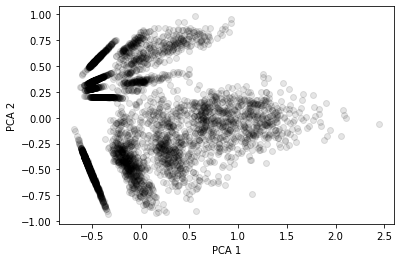

In [25]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [72]:
# X will be training data 
X = principalComponents[:, :important_PCA_number]


### DBSCAN


In [86]:
# parameter
X = principalComponents[:, :important_PCA_number]
db = DBSCAN(eps=0.5, min_samples=30).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
# print(
#     "Adjusted Mutual Information: %0.3f"
#     % metrics.adjusted_mutual_info_score(labels_true, labels)
# )
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 11
Estimated number of noise points: 255
Silhouette Coefficient: 0.314


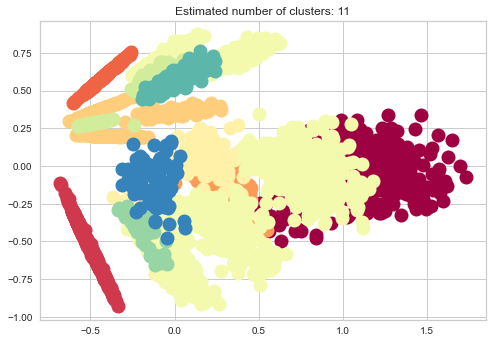

In [87]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    # xy = X[class_member_mask & ~core_samples_mask]
    # plt.plot(
    #     xy[:, 0],
    #     xy[:, 1],
    #     "o",
    #     markerfacecolor=tuple(col),
    #     markeredgecolor="k",
    #     markersize=6,
    # )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

## Create the customer segments with K-means++ algorithm 

In [29]:
# # Fit KMeans and calculate SSE for each *k*
# sse = {}
# for k in range(1, 20, 2):
#     kmeans = KMeans(n_clusters=k, random_state=1)
#     kmeans.fit(principalComponents[:, :important_PCA_number])
#     sse[k] = kmeans.inertia_
# # Plot SSE for each *k*
# plt.title('The Elbow Method')
# plt.xlabel('k'); plt.ylabel('SSE')
# sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
# plt.show();

For n_clusters = 11 The average silhouette_score is : 0.31390105902581483


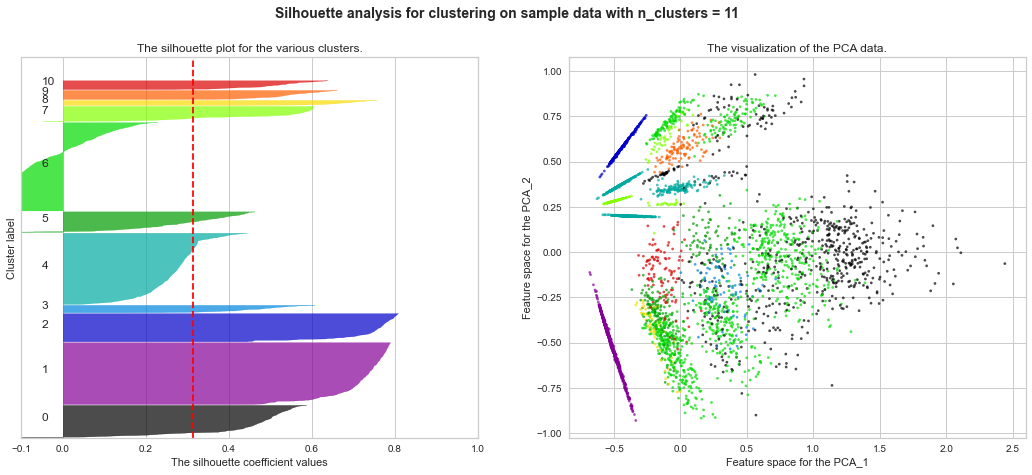

In [88]:
from sklearn import metrics
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm

# X = ad_data_process_norm

db = DBSCAN(eps=0.5, min_samples=30).fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters_ + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.


# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = metrics.silhouette_score(X, labels)
print(
    "For n_clusters =",
    n_clusters_,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(X, labels)

y_lower = 10
for i in range(n_clusters_):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters_)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(labels.astype(float) / n_clusters_)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

ax2.set_title("The visualization of the PCA data.")
ax2.set_xlabel("Feature space for the PCA_1")
ax2.set_ylabel("Feature space for the PCA_2")

plt.suptitle(
    "Silhouette analysis for clustering on sample data with n_clusters = %d"
    % n_clusters_,
    fontsize=14,
    fontweight="bold",
)

plt.show()

In [31]:
# PCA does not change the relative relationship among features. If the dimension of PCA is the same as the original one,
# silhouette score will not be changed. However, using PCA is better to visualize data clusters
# Data points between clusters seperated well

### Train Decision Tree to interpret the data

In [89]:
X.shape, labels.shape

((4272, 8), (4272,))

In [90]:
(labels == -1).sum()

255

In [91]:
X_remove_noise = X[labels != -1]
labels_remove_noise = labels[labels != -1]

X_remove_noise.shape, labels_remove_noise.shape

((4017, 8), (4017,))

In [92]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

clf = clf.fit(X_remove_noise, labels_remove_noise)


In [93]:
feature_names = [f'PCA_{i}' for i in range(important_PCA_number)]
print(f'features_names: {feature_names}')

class_names = [f'class_{i}' for i in range(n_clusters_)]
print(f'n_clusters: {class_names}')

features_names: ['PCA_0', 'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7']
n_clusters: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'class_10']


In [95]:
import graphviz # have to use pip install, not conda. And install by installer also
import os

dot_data = tree.export_graphviz(clf, out_file=None, 
    feature_names=feature_names,  
                    class_names=class_names,  
                    filled=True, rounded=True,  
                    special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("./customer_segmentation_tree") 

'.\\customer_segmentation_tree.pdf'

* how evaluate customer segmentation 
- T: >= 6 months ---> long term user , < 6 months ---> short-term user 
- R: >= 1 month --> lost user, < 1 motnh --> non-lost user 
- F and M: Both >= 50% -> valuable user ,Both < 5-% -> non-valuable user 

# Hierarchical Clustering

## Dendrograms for Hierarchical Clustering

In [61]:
X.shape[0]

4272

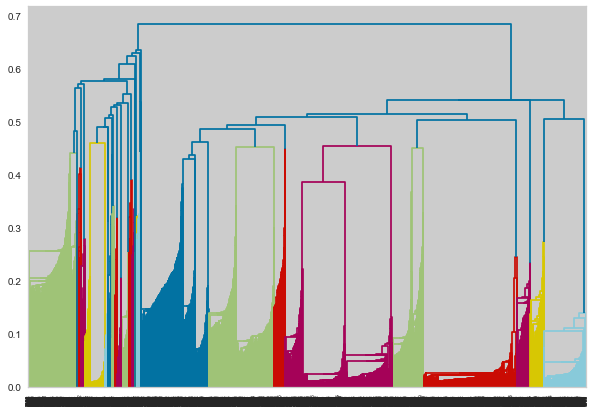

In [62]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

labelList = range(1, X.shape[0]+1)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [ ]:
# denogram, how to get the number of cluster? 

## Hierarchical Clustering via Scikit-Learn


In [76]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', compute_full_tree=True, distance_threshold=10)
cluster.fit_predict(X)
labels = cluster.labels_
print(f"Number of clusters = {1+np.amax(cluster.labels_)}")


Number of clusters = 15


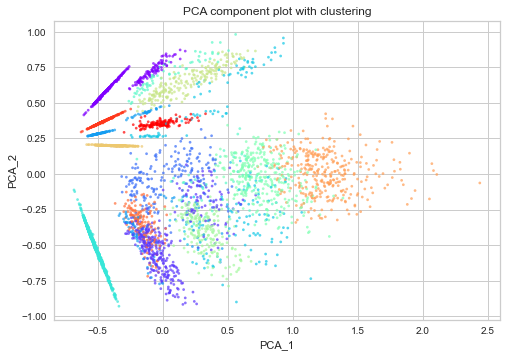

In [70]:
plt.scatter(
        PCA_components.iloc[:, 0], PCA_components.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=labels, cmap = 'rainbow', edgecolor="k"
    )
plt.title('PCA component plot with clustering')
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()

In [78]:
n_clusters = 1+np.amax(cluster.labels_)
n_clusters

15

For n_clusters = 15 The average silhouette_score is : 0.49140696398288186


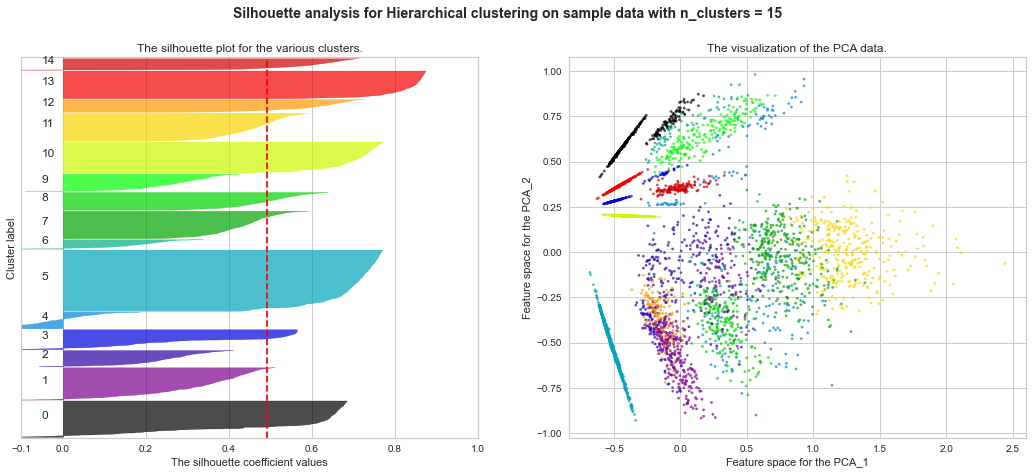

In [79]:
from sklearn import metrics
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.cm as cm


n_clusters = 1+np.amax(cluster.labels_)
# X = ad_data_process_norm

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)
cluster_labels = cluster.labels_

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = metrics.silhouette_score(X, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)


ax2.set_title("The visualization of the PCA data.")
ax2.set_xlabel("Feature space for the PCA_1")
ax2.set_ylabel("Feature space for the PCA_2")

plt.suptitle(
    "Silhouette analysis for Hierarchical clustering on sample data with n_clusters = %d"
    % n_clusters,
    fontsize=14,
    fontweight="bold",
)

plt.show()